<h1>VRI Productivity Analysis - DuckDB</h1>

This notebook uses DuckDB and the VRI Parquet file on NRS objectstore to download the VRI, clip to an AOI and preform analysis of site index values. It was created for WMB Planning in the Northeast Region as part of the Blueberry River First Nation Implementation Agreement. Written by North Ross in October 2024.

DuckDB is used due to its very fast processing time with large datasets such as the VRI, especially when preforming clips, intersects and spatial joins. The initial idea for this analysis was to combine with the PSPL data. This did not end up being used in the final product, but the PSPL_testing.ipynb noteboook preserves my experimenting with it. DuckDB was very useful for this operation.

<a href="https://jupysql.ploomber.io/en/latest/api/magic-plot.html">JupySQL</a> is used to execute the DuckDB SQL and create plots, except in some cases where the duckdb conn.sql() function is used to implement directly in Python (in a loop for example)

Further experiments could use <a href="https://developmentseed.org/lonboard/latest/">lonboard</a> with the .from_duckdb() method to try quickly visually inspecting the data.

Otherwise, you can export the data to another format or use the <a href="https://plugins.qgis.org/plugins/qduckdb/">QGIS DuckDB extension</a> to plot the data (this works well in this case and is quite fast)

In [ ]:
# install some libraries (if not already installed)
%pip install --upgrade duckdb
%pip install jupysql
%pip install duckdb-engine
%pip install matplotlib

In [1]:
# load libraries/jupyter extensions
import pandas as pd
import duckdb
from shapely.geometry import shape
import fiona
import os
%load_ext sql

There's a new jupysql version available (0.10.16), you're running 0.10.12. To upgrade: pip install jupysql --upgrade
Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


In [2]:
# sql ggplot
from sql.ggplot import ggplot, aes, geom_boxplot, geom_histogram, facet_wrap

In [2]:
# Set local variables, paths to AOI, vri, other data.
# Note the aflb data is not yet incorporated into the script.

# conn = duckdb.connect(database=':memory:')
workingdir = r'C:\Working\WMBAnalysis'
db = os.path.join(workingdir,'vri_analysis.db')
vri_url = "https://nrs.objectstore.gov.bc.ca/rczimv/geotest/veg_comp_layer_r1_poly.parquet"
aoi_path = r'\\spatialfiles2.bcgov\work\FOR\RNI\DPC\General_User_Data\nross\BRFN_NE_LUPCE_Analysis\WMB_Study_Area_2024_07_30\WMB_Study_Area_2024_07_30.shp'
brfn_gdb = r'\\spatialfiles.bcgov\work\srm\nr\NEGSS\NEDD\First_Nations_Agreements\BRFN_Implementation_Agreement\FileGeodatabase\BRFNAgreement.gdb'


conn = duckdb.connect(database=db)
# conn.install_extension("httpfs")
# conn.install_extension("spatial")
# conn.load_extension("httpfs")
conn.load_extension("spatial")


In [14]:
# if it did not close properly...
conn=duckdb.connect()
conn.load_extension("spatial")
conn.sql(f"attach '{db}' as vri_analysis")
conn.sql(f"use vri_analysis")
conn.sql("DROP INDEX IF EXISTS idx")
conn.sql("DROP INDEX IF EXISTS idx_fwa")
conn.close()
# then rerun above

In [3]:
# Setup sql magic and show current tables
%sql conn --alias duckdb
%sql select * from information_schema.tables

Running query in 'duckdb'

table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action,TABLE_COMMENT
vri_analysis,main,aflb,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,AFLB_own,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,cut,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,fwa,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,fwa_simple,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,hv1,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,midaspen,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,own,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,pspl,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,vri,BASE TABLE,None,None,None,None,None,YES,NO,None,None


In [4]:
# read AOI as shapely geom
with fiona.open(aoi_path) as shapefile:
    aoi = shape(shapefile[0]['geometry'])
    aoi_area_ha = aoi.area/10000
    print(round(aoi_area_ha, 2))


DriverError: \\spatialfiles2.bcgov\work\FOR\RNI\DPC\General_User_Data\nross\BRFN_NE_LUPCE_Analysis\WMB_Study_Area_2024_07_30\WMB_Study_Area_2024_07_30.shp: No such file or directory

In [16]:
# read BRFN layers as geopandas df
import geopandas as gpd

wmb_gdf = gpd.GeoDataFrame.from_file(brfn_gdb, layer='Priority_WMB')
# add Cameron River WMB
cam_gdf = gpd.GeoDataFrame.from_file(brfn_gdb, layer='CameronR_WMB')
cam_gdf['WATER_MANAGEMENT_BASIN_NAME'] = cam_gdf['BASIN_NAME']
wmb_gdf = pd.concat([wmb_gdf, cam_gdf])
wmb_gdf['wkt'] = wmb_gdf['geometry'].to_wkt()
wmb_gdf = wmb_gdf.drop(columns='geometry')
conn.sql("CREATE TABLE IF NOT EXISTS wmb AS (SELECT WATER_MANAGEMENT_BASIN_NAME AS WMB_NAME,  ST_GeomFromText(wkt) as GEOM FROM wmb_gdf)")
del wmb_gdf, cam_gdf

hv1_gdf  =gpd.GeoDataFrame.from_file(brfn_gdb, layer='BRFN_HV1')
hv1_gdf['wkt'] = hv1_gdf['geometry'].to_wkt()
hv1_gdf = hv1_gdf.drop(columns='geometry')
conn.sql("CREATE TABLE IF NOT EXISTS hv1 AS (SELECT Name as HV1Name, Zone_A_B_C, ZoneLabel as HV1ZoneLabel, ST_GeomFromText(wkt) as GEOM FROM hv1_gdf)")
del hv1_gdf


<h1>Download VRI</h1>

The next section downloads the relevant 2023 VRI R1 data by querying a parquet object in the nrs object storage, then clips it to our AOI. This operation is much faster when working in memory.

In [6]:
%%sql
# create vri table
CREATE OR REPLACE TABLE vri as (
    select Shape as geom, OBJECTID,
      BCLCS_LEVEL_1, BCLCS_LEVEL_2, BCLCS_LEVEL_3, FOR_MGMT_LAND_BASE_IND,
      BEC_ZONE_CODE, bec_subzone, bec_phase, bec_variant,
      SPECIES_CD_1, SPECIES_PCT_1, SPECIES_CD_2, SPECIES_PCT_2, SPECIES_CD_3, SPECIES_PCT_3,
      SPECIES_CD_4, SPECIES_PCT_4, SPECIES_CD_5, SPECIES_PCT_5, SPECIES_CD_6, SPECIES_PCT_6,
      est_site_index, est_site_index_source_cd, est_site_index_species_cd,
      PROJ_AGE_CLASS_CD_1, harvest_date, SITE_INDEX, POLYGON_AREA
    from '{{vri_url}}' -- read parquet file from objectstorage
    where ST_Intersects (geom, ST_GeomFromText('{{aoi}}'))
);

Running query in 'duckdb'

Count
188049


In [7]:
%%sql
# Clip VRI to AOI
UPDATE vri
SET geom = (
    SELECT
        CASE WHEN ST_Intersects(geom, ST_Boundary(ST_GeomFromText('{{aoi}}')))
                THEN ST_Intersection(geom, ST_GeomFromText('{{aoi}}'))
                ELSE geom END
    from vri v
    WHERE vri.OBJECTID = v.OBJECTID
    );

UPDATE vri
set POLYGON_AREA = ST_Area(geom)/10000;

Running query in 'duckdb'

Count
188049


In [5]:
# Add tables for cutblocks, fwa and ownership
aoiBoundsStr = str(aoi.bounds)

intersectString = f"""
SDO_GEOMETRY(2003, 3005, NULL,
        SDO_ELEM_INFO_ARRAY(1,1003,3),
        SDO_ORDINATE_ARRAY{aoiBoundsStr} 
    )
"""

cut_osql = f"""
    SELECT OBJECTID, SHAPE
    FROM WHSE_FOREST_VEGETATION.VEG_CONSOLIDATED_CUT_BLOCKS_SP
    WHERE SDO_ANYINTERACT (SHAPE,{intersectString}) = 'TRUE'
"""

fwa_osql =  f"""
        SELECT OBJECTID, GEOMETRY AS SHAPE
        FROM WHSE_BASEMAPPING.FWA_LAKES_POLY
        WHERE SDO_ANYINTERACT (GEOMETRY,{intersectString}) = 'TRUE'
    UNION ALL
        SELECT OBJECTID, GEOMETRY AS SHAPE
        FROM WHSE_BASEMAPPING.FWA_WETLANDS_POLY
        WHERE SDO_ANYINTERACT (GEOMETRY,{intersectString}) = 'TRUE'
    UNION ALL
        SELECT OBJECTID, GEOMETRY AS SHAPE
        FROM WHSE_BASEMAPPING.FWA_RIVERS_POLY
        WHERE SDO_ANYINTERACT (GEOMETRY,{intersectString}) = 'TRUE'
        """
        
own_osql = f"""
    SELECT OBJECTID, 
        CASE 
            WHEN OWN NOT IN (40, 52, 54, 77, 80, 81, 91, 99) 
            THEN 'AFLB' 
            ELSE 'IFLB' 
        END AS OWN_AFLB,
        GEOMETRY
    FROM WHSE_FOREST_VEGETATION.F_OWN
    WHERE SDO_ANYINTERACT (GEOMETRY,{intersectString}) = 'TRUE'
                """ 
import sys
sys.path.append("\\spatialfiles2.bcgov\work\FOR\RNI\DPC\General_User_Data\nross\BRFN_NE_LUPCE_Analysis\scripts\WMB_Analysis")
from bcgw2gdf import bcgw2gdf
bcgw2gdf = bcgw2gdf()


In [9]:
cut_df = bcgw2gdf.get_spatial_table(cut_osql) 
fwa_df = bcgw2gdf.get_spatial_table(fwa_osql) 
own_df = bcgw2gdf.get_spatial_table(own_osql)

conn.sql(f"CREATE TABLE IF NOT EXISTS cut AS (SELECT OBJECTID, (ST_GeomFromText(wkt)) as GEOM FROM cut_df)")
conn.sql(f"CREATE TABLE IF NOT EXISTS fwa AS (SELECT OBJECTID, (ST_GeomFromText(wkt)) as GEOM, ST_Area(GEOM)/10000 as POLYGON_AREA FROM fwa_df)")
conn.sql(f"CREATE TABLE IF NOT EXISTS own AS (SELECT OBJECTID, OWN_AFLB, (ST_GeomFromText(wkt)) as GEOM FROM own_df)")
del cut_df, fwa_df, own_df

INFO:root:spatial query returned as GeoDataFrame
INFO:root:spatial query returned as GeoDataFrame
INFO:root:spatial query returned as GeoDataFrame


In [5]:
%%sql 
drop table if exists fwa_simple;

create table if not exists fwa_simple as (
    SELECT OBJECTID, ST_Simplify(geom, 10) as GEOM, ST_AREA(ST_Simplify(geom, 10)) as POLYGON_AREA
    from fwa
    where POLYGON_AREA > 0.5
);


CREATE INDEX IF NOT EXISTS idx ON vri USING RTREE (geom);

Running query in 'duckdb'

Count


In [29]:
%%sql
select '0' as "min area", count(objectid), sum(ST_NPoints(geom)), sum(polygon_area), sum(ST_NPoints(ST_Simplify(geom, 1))), sum(ST_Area(ST_Simplify(geom, 1)))/10000 from fwa where polygon_area > 0
union all
select '0.5' as "min area", count(objectid), sum(ST_NPoints(geom)), sum(polygon_area), sum(ST_NPoints(ST_Simplify(geom, 1))), sum(ST_Area(ST_Simplify(geom, 1)))/10000 from fwa where polygon_area > 0.5
# union all
# select '5', count(objectid), sum(ST_NPoints(geom)), sum(polygon_area) from fwa where polygon_area > 5
# union all
# select '25', count(objectid), sum(ST_NPoints(geom)), sum(polygon_area) from fwa where polygon_area > 25
# union all
# select '100', count(objectid), sum(ST_NPoints(geom)), sum(polygon_area) from fwa where polygon_area > 100

Running query in 'duckdb'

min area,count(objectid),sum(st_npoints(geom)),sum(polygon_area),"sum(st_npoints(st_simplify(geom, 1)))","(sum(st_area(st_simplify(geom, 1))) / 10000)"
0,32389,4024322,670867.3310873717,2347125,670841.3953598439
0.5,20995,3780847,668561.3464576767,2176990,668541.392765821


In [10]:
%%sql
# Create a spatial index (RTree) for faser performance
DROP INDEX IF EXISTS idx;
CREATE INDEX IF NOT EXISTS idx ON vri USING RTREE (geom);

Running query in 'duckdb'

Count


In [11]:
%%sql
ALTER TABLE vri
DROP IF EXISTS aflb_fact;

ALTER TABLE vri
ADD COLUMN aflb_fact FLOAT;

UPDATE vri
    SET aflb_fact = 1.0
        where BCLCS_LEVEL_1 != 'N' AND BCLCS_LEVEL_2 != 'W' AND BCLCS_LEVEL_3 != 'W' AND FOR_MGMT_LAND_BASE_IND != 'N';


Running query in 'duckdb'

DependencyException: Dependency Error: Cannot alter entry "vri" because there are entries that depend on it.

In [12]:
%%sql
DROP TABLE IF EXISTS aflb;
CREATE TABLE aflb as (
    SELECT OBJECTID, GEOM
    FROM vri
    where BCLCS_LEVEL_1 != 'N' AND BCLCS_LEVEL_2 != 'W' AND BCLCS_LEVEL_3 != 'W' AND FOR_MGMT_LAND_BASE_IND != 'N'
);

SELECT SUM(ST_Area(GEOM))/10000 from aflb

Running query in 'duckdb'

(sum(st_area(GEOM)) / 10000)
1799415.026048242


In [13]:
%%sql
# Insert cutblock areas to aflb
INSERT INTO aflb 
    SELECT
        vri.OBJECTID,
        ST_Union_Agg(ST_Intersection(vri.geom, cut.geom)) AS GEOM
    FROM vri 
    JOIN cut ON st_intersects(vri.geom, cut.geom)
    WHERE NOT (
        BCLCS_LEVEL_1 != 'N' AND BCLCS_LEVEL_2 != 'W' AND BCLCS_LEVEL_3 != 'W' AND FOR_MGMT_LAND_BASE_IND != 'N'
        ) --# Only get this outside the "core area"
    GROUP BY vri.OBJECTID;
    
SELECT SUM(ST_Area(GEOM))/10000 from aflb;

Running query in 'duckdb'

(sum(st_area(GEOM)) / 10000)
1801013.9162573104


In [75]:
%%sql
# All vri polygons completely covered by FWA - remove these from AFLB
DELETE FROM aflb a
WHERE ST_CoveredBy(
    a.geom,
    (
        SELECT ST_Union_Agg(b.geom)
        FROM fwa_simple as b
        where ST_Intersects(a.geom, b.geom)
    )
)

Running query in 'duckdb'

Count
0


(1484686.5139, 1485049.7163000002)

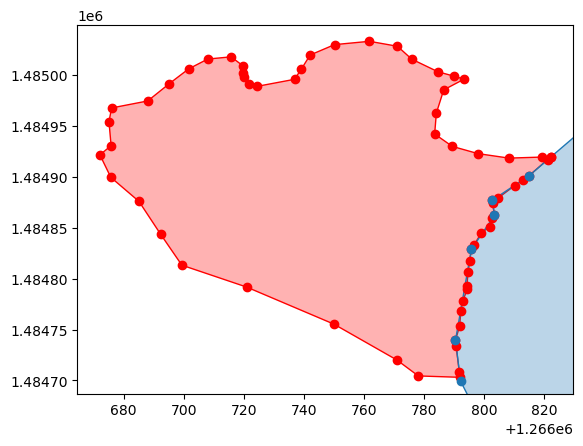

In [70]:
from shapely import plotting
import matplotlib.pyplot as plt
poly = conn.sql("select ST_AsText(fwa.geom) AS fwageom, ST_AsText(aflb.geom) as aflbgeom from aflb JOIN fwa_simple fwa ON ST_Overlaps(aflb.geom, fwa.geom) where aflb.objectid = 3924650").df()
geom1 = from_wkt(poly.iloc[0, 0])
geom2 = from_wkt(poly.iloc[0, 1])

fig, ax = plt.subplots()
plotting.plot_polygon(geom2, ax, color='red')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plotting.plot_polygon(geom1, ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.plot(*geom1.exterior.xy)
# ax.plot(*geom2.exterior.xy)

# poly.iloc[0,1]

In [6]:
%%sql
select count(aflb.objectid)
    # COUNT_IF (ST_Overlaps(aflb.geom, fwa.geom))
from aflb JOIN fwa_simple fwa ON ST_Overlaps(aflb.geom, fwa.geom)

Running query in 'duckdb'

count(aflb.objectid)
50175


In [7]:
%%sql
# remove FWA areas from AFLB geometry
# If this doesn't work then try just getting the area of intersect and not updating geometry. After intersecting with ownership
UPDATE aflb
SET GEOM = clip.GEOM
FROM aflb a_old
INNER JOIN (
    SELECT
        aflb.OBJECTID, 
        ST_Difference(aflb.geom, ST_Union_Agg(fwa.geom)) AS geom
    FROM aflb
        JOIN fwa_simple fwa ON ST_Overlaps(aflb.geom, fwa.geom)
    GROUP BY aflb.OBJECTID, aflb.geom
    ) clip ON a_old.OBJECTID = clip.OBJECTID

Running query in 'duckdb'

OutOfMemoryException: Out of Memory Error: failed to allocate data of size 16.0 MiB (24.9 GiB/25.0 GiB used)

In [21]:
%%sql 
# Reduce the AFLB area based on simplified FWA area overlap
# This worked once in a reasonable time....
UPDATE aflb
SET AreaHa = clip.aflbArea
FROM aflb a_old
INNER JOIN (
SELECT
    aflb.OBJECTID, 
    ST_AREA(ST_Union_Agg(ST_Difference(aflb.geom, fwa.geom)))/10000 as aflbArea
FROM aflb
    JOIN fwa_simple fwa ON st_intersects(aflb.geom, fwa.geom)
GROUP BY aflb.OBJECTID
) clip ON a_old.OBJECTID = clip.OBJECTID

Running query in 'duckdb'

OBJECTID,count,fwaarea,aflbArea
3753855,1,401.0847215318316,2.5851900827120464
254493,1,2756.159550418038,1.4723503557581523
2149491,1,459.34295341170383,2.029115823798048
3268131,1,2756.159550418038,5.151163839339458
593471,1,4.630195586350329,0.1333565595766157


In [15]:
%%sql
# Intersect AFLB with ownership layer

CREATE OR REPLACE TABLE AFLB_own AS (
    SELECT OBJECTID, OWN_AFLB, ST_Area(GEOM)/10000 as AreaHa, GEOM
    FROM (
        SELECT aflb.OBJECTID, ST_Intersection(aflb.geom, own.geom) AS GEOM,
                own.OWN_AFLB as OWN_AFLB
        FROM aflb
            JOIN own ON st_intersects(aflb.geom, own.geom)
    )
);

Running query in 'duckdb'

Count
188941


In [16]:
%%sql
# add AFLB factor
UPDATE vri
SET aflb_fact = aflb.AreaHa / vri.POLYGON_AREA
FROM AFLB_own aflb
WHERE vri.OBJECTID = aflb.OBJECTID
AND aflb.OWN_AFLB = 'AFLB';

UPDATE vri
SET aflb_fact = 0
WHERE aflb_fact IS NULL;

Running query in 'duckdb'

Count
0


In [11]:
%%sql
# add IFLB
CREATE VIEW iflb_fact_v as
SELECT a_new.OBJECTID,
    SUM(a_new.AreaHa) / SUM(vri.POLYGON_AREA) as iflb_fact
FROM aflb_own a_new
    JOIN vri USING (OBJECTID)
GROUP BY a_new.OBJECTID;

ALTER TABLE vri
ADD COLUMN IF NOT EXISTS iflb_fact DOUBLE;

UPDATE vri v
SET iflb_fact = i.iflb_fact
FROM iflb_fact_v i
WHERE v.OBJECTID = i.OBJECTID

Running query in 'duckdb'

Count


In [37]:
%%sql
# Add AFLB area
# This seems to not be working...
# Copy AFLB from AFLB database
# ATTACH IF NOT EXISTS 'C:\Users\nross\OneDrive - Government of BC\Documents\BRFNDocs\aflb-test\aflb.db' AS aflb_db;
ALTER TABLE vri_wmb 
ADD COLUMN IF NOT EXISTS aflb_fact
SELECT 
    IF( a.OWN_AFLB = 'AFLB',
        IF(ST_Intersects(vri.GEOM, ST_Boundary(a.GEOM)), 
            ST_Area(ST_Intersection(vri.GEOM, a.GEOM))*10000 / vri.POLYGON_AREA,
            1
         ), 0
        ) AS aflb_fact,
    
    IF( a.OWN_AFLB = 'IFLB',
        IF(ST_Intersects(vri.GEOM, ST_Boundary(a.GEOM)), 
            ST_Area(ST_Intersection(vri.GEOM, a.GEOM))*10000 / vri.POLYGON_AREA,
            1
         ), 0
        ) AS IFLB_fact,
       
    FROM vri, aflb_db.aflb a
WHERE 
    vri.BCLCS_LEVEL_1 != 'N' AND vri.BCLCS_LEVEL_2 != 'W' AND vri.BCLCS_LEVEL_3 != 'W' AND vri.FOR_MGMT_LAND_BASE_IND != 'N'
    AND
    ST_INTERSECTS(vri.GEOM, a.GEOM)

# DETACH aflb_db



Running query in 'duckdb'

In [9]:
# check if VRI area roughly matches AOI input. 
%sql select FORMAT('{:t,.2f}', sum(polygon_area)) AS VRIAreaHa, FORMAT('{:t,.2f}', {{aoi_area_ha}}) as AOIAreaHa from vri

Running query in 'duckdb'

VRIAreaHa,AOIAreaHa
"2,179,740.98","2,179,741.04"


<h2>Deciduous Percent</h2>

Calculate Deciduous Percent and Stand Type. We use 25% cutoff.

The <a>VRI Data Dictionary</a> lists tree species codes under the entry for SPECIES_CD_1. All "hardwood species" codes were put into deciduousList, although most do not occur in our study area (especially as leading species). We only use the first letter to catch entries which only look at first letter (e.g. undifferentiated poplar = 'A')



In [31]:
# Create deciduous % column
deciduousList = ['A', 'D', 'E', 'G', 'K', 'M', 'Q', 'R', 'U', 'V', 'W']
deciduousListStr = ("(\'" + "\', \'".join(deciduousList) + "\')")

In [32]:
%%sql
ALTER TABLE vri 
ADD COLUMN IF NOT EXISTS DECID_PCT DOUBLE;

ALTER TABLE vri 
ADD COLUMN IF NOT EXISTS STAND_TYPE_25 VARCHAR;

# For each of the six species codes, if the first letter is in our list of deciduous species, add it to our DECID_PCT column. Else add zero.
UPDATE vri
SET DECID_PCT = (
  CASE WHEN SPECIES_CD_1[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_1 ELSE 0 END +
  CASE WHEN SPECIES_CD_2[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_2 ELSE 0 END +
  CASE WHEN SPECIES_CD_3[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_3 ELSE 0 END +
  CASE WHEN SPECIES_CD_4[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_4 ELSE 0 END +
  CASE WHEN SPECIES_CD_5[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_5 ELSE 0 END +
  CASE WHEN SPECIES_CD_6[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_6 ELSE 0 END
);

# If no leading species is listed (SPECIES_CD_1 = NULL), set DECID_PCT to NULL.
UPDATE vri
SET DECID_PCT = (
  CASE WHEN SPECIES_CD_1 IS NULL THEN NULL ELSE DECID_PCT END
);

# Use 25% cutoffs to assign a stand type. If DECID_PCT is NULL then set this to NULL.
UPDATE vri
SET STAND_TYPE_25 = (
  CASE WHEN DECID_PCT <= 25 THEN 'Coniferous' ELSE 
    CASE WHEN DECID_PCT >= 75 THEN 'Deciduous' ELSE 
      CASE WHEN DECID_PCT IS NOT NULL THEN 'Mixed' ELSE NULL END
    END
  END
);

Running query in 'duckdb'

Count
188049


In [12]:
%sql select MAX(DECID_PCT) from vri

Running query in 'duckdb'

max(DECID_PCT)
100.0


In [13]:
# Weirdly there are some polygons that have a site index but no listed leading species...
%sql select count(SITE_INDEX), sum(POLYGON_AREA), avg(SITE_INDEX) from vri where SPECIES_CD_1 is null and SITE_INDEX is not null

Running query in 'duckdb'

count(SITE_INDEX),sum(POLYGON_AREA),avg(SITE_INDEX)
230,3017.180842383417,15.560869565217391


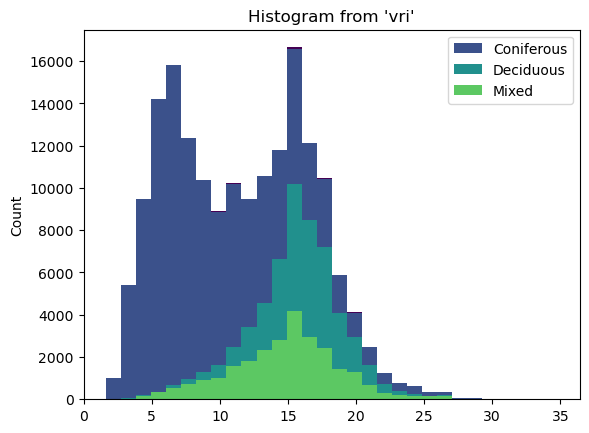

In [14]:
# Take a look at the output
# Note that sql.ggplot() doesn't support the 'weights' argument so we can't weight the polygons by area. So this is just looking at the number of polygons with x site index. 
# We could group these into bins and then do a bar chart but this would take time to both code and process. So it's faster to just do it in R.
# This is slightly different from the actual area. See the R script for proper charts.
(ggplot("vri", aes(x="SITE_INDEX")) + geom_histogram(bins=30, fill="STAND_TYPE_25", cmap='viridis_r'))

<h2>Productivity Bins</h2>

The above data was loaded into R to inspect the distribution of site index within each stand type by leading species. See 'SiteIndexAnalysis.R' and the discussion paper.

It was determined to use the following categories for our productivity bins:

<b>Coniferous</b>: <= 10 is Low, >= 18 is High

<b>Deciduous</b>: <= 12 is Low, >= 20 is High

<b>Mixed</b>: <= 10 is low, >= 20 is High

In [33]:
%%sql
ALTER TABLE vri
ADD COLUMN IF NOT EXISTS prod_bin VARCHAR;

# Sort into productivity bins

UPDATE vri
SET prod_bin = 
IF (
    STAND_TYPE_25 = 'Coniferous',
    IF (
        SITE_INDEX <= 10,
        'Low',
        IF (
            SITE_INDEX >= 18,
            'High',
            IF (SITE_INDEX IS NOT NULL, 'Medium', NULL)
            )
        ),
    IF (STAND_TYPE_25 = 'Deciduous',
        IF (
            SITE_INDEX <= 12,
            'Low',
            IF (
                SITE_INDEX >= 20,
                'High',
                IF (SITE_INDEX IS NOT NULL, 'Medium', NULL)
                )
            ),
        IF (STAND_TYPE_25 = 'Mixed',
            IF (
                SITE_INDEX <= 10,
                'Low',
                IF (
                    SITE_INDEX >= 20,
                    'High',
                    IF (SITE_INDEX IS NOT NULL, 'Medium', NULL)
                    )
                ),
            NULL
        )
    )
)


Running query in 'duckdb'

Count
188049


In [26]:
%sql select * from wmb LIMIT 0

Running query in 'duckdb'

WMB_NAME,GEOM


In [27]:
%%sql
# %sql DROP TABLE IF EXISTS vri_wmb;

CREATE OR REPLACE TABLE vri_wmb AS (
    SELECT vri.OBJECTID AS OBJECTID,
        wmb.WMB_NAME,
        ST_Intersection(vri.GEOM, wmb.GEOM) AS GEOM
    FROM vri, wmb
    WHERE ST_Intersects(vri.geom, wmb.GEOM)
);


Running query in 'duckdb'

Count
111172


In [34]:
%%sql
# intersect and join with planning WMB areas
# Intersect these with the VRI to add wmb attributes

# add VRI inside the WMBs
DROP TABLE IF EXISTS vri_wmb;

CREATE OR REPLACE TABLE vri_wmb AS (
    SELECT vri.OBJECTID AS OBJECTID,
        wmb.WMB_NAME,
        ST_Intersection(vri.GEOM, wmb.GEOM) AS GEOM
    FROM vri
        JOIN wmb ON ST_Intersects(vri.geom, wmb.GEOM)
);

# add VRI interesecting WMB boundary but outside
INSERT INTO vri_wmb (
    SELECT vri.OBJECTID AS OBJECTID,
        NULL AS WMB_NAME,
        ST_Difference(vri.GEOM, wmb.GEOM) AS GEOM
    FROM vri
        JOIN wmb ON ST_Intersects(vri.geom, wmb.GEOM)
);

# Add the rest of the VRI that was not already added
INSERT INTO vri_wmb (
    SELECT OBJECTID,
        NULL AS WMB_NAME,
        GEOM
    FROM vri
    WHERE OBJECTID NOT IN (SELECT OBJECTID FROM vri_wmb)
    );

# Join all other VRI attributes in view
CREATE OR REPLACE VIEW vri_wmb_v as (
    SELECT v.OBJECTID, v.GEOM, v.WMB_NAME, ST_Area(v.GEOM)/10000 as POLYGON_AREA,
        IF(WMB_NAME != 'Cameron River' OR WMB_NAME IS NOT NULL, 1, NULL) AS priority_WMB,
        vri.* EXCLUDE (OBJECTID, GEOM, POLYGON_AREA)
    FROM vri_wmb v
    LEFT JOIN vri USING (OBJECTID)
);

Running query in 'duckdb'

Count


In [81]:
%%sql
CREATE OR REPLACE VIEW vri_wmb_v as (
    SELECT v.OBJECTID, v.GEOM, v.WMB_NAME, ST_Area(v.GEOM)/10000 as POLYGON_AREA,
        IF(WMB_NAME != 'Cameron River' OR WMB_NAME IS NOT NULL, 1, NULL) AS priority_WMB,
        vri.* EXCLUDE (OBJECTID, GEOM, POLYGON_AREA)
    FROM vri_wmb v
    LEFT JOIN vri USING (OBJECTID)
);

Running query in 'duckdb'

Count


In [46]:
%config SqlMagic.displaylimit = 40

In [12]:
%%sql 
# Examine distribution of outputs.
SELECT 
    STAND_TYPE_25 as "Stand Composition", 
    prod_bin as "Productivity Class", 
    ROUND(AVG(SITE_INDEX), 1) as "Mean Site Index", 
    FORMAT('{:t,.0f}', SUM(POLYGON_AREA)) AS "Total Area (ha)",
    ROUND(SUM(POLYGON_AREA) * 100.0 / SUM(SUM(POLYGON_AREA)) OVER (PARTITION BY STAND_TYPE_25), 1) AS "% of Stand Type Area",
    ROUND(SUM(POLYGON_AREA) * 100.0 / SUM(SUM(POLYGON_AREA)) OVER (), 1) AS "% of Study Area"
    

from vri 
    GROUP BY STAND_TYPE_25, prod_bin
    ORDER BY STAND_TYPE_25, "Mean Site Index", "Total Area (ha)"

Running query in 'duckdb'

Stand Composition,Productivity Class,Mean Site Index,Total Area (ha),% of Stand Type Area,% of Study Area
Coniferous,Low,6.5,"880,961",64.2,40.4
Coniferous,Medium,13.5,"406,480",29.6,18.6
Coniferous,High,20.4,"80,715",5.9,3.7
Coniferous,None,None,"3,648",0.3,0.2
Deciduous,Low,10.2,"33,720",8.6,1.5
Deciduous,Medium,16.2,"327,416",83.7,15.0
Deciduous,High,21.6,"29,997",7.7,1.4
Deciduous,None,None,106,0.0,0.0
Mixed,Low,7.8,"36,563",12.8,1.7
Mixed,Medium,15.1,"223,044",78.0,10.2


In [88]:
%%sql 
select sum(IF(priority_WMB == 1, iflb_fact * POLYGON_AREA, 0.0)), SUM(iflb_fact * POLYGON_AREA) from vri_wmb_v


Running query in 'duckdb'

sum(CASE WHEN ((priority_WMB = 1)) THEN ((iflb_fact * POLYGON_AREA)) ELSE 0.0 END),sum((iflb_fact * POLYGON_AREA))
931352.6951731975,1587912.409648098


In [79]:
%%sql
# conn.sql("""
SELECT 
    STAND_TYPE_25 as "Stand Composition", 
    prod_bin as "Productivity Class", 
    BEC_ZONE_CODE, BEC_SUBZONE,
    SUM(SUM(POLYGON_AREA)) OVER () as StudyAREA,
    CONCAT(BEC_ZONE_CODE, BEC_SUBZONE) as "BEC String",
    SUM(SUM(IF(priority_WMB == 1, POLYGON_AREA, 0.0))) OVER () as totalWMB,
    (100.0 * 
            SUM(IF(priority_WMB == 1, POLYGON_AREA, 0.0)) / 
            SUM(SUM(IF(priority_WMB == 1, POLYGON_AREA, 0.0))) OVER ()
        ) AS "% of WMB Area",
    (100.0 * 
            SUM(IF(priority_WMB == 1, aflb_fact * POLYGON_AREA, 0.0)) / 
            SUM(SUM(IF(priority_WMB == 1, aflb_fact * POLYGON_AREA, 0.0))) OVER ()
        ) AS "% AFLB in WMB Area",
    (100.0 * SUM(aflb_fact * POLYGON_AREA) /
            SUM(SUM(aflb_fact * POLYGON_AREA)) OVER ()
        ) AS "% AFLB in Study Area",
    (100.0 * SUM(POLYGON_AREA) / SUM(SUM(POLYGON_AREA)) OVER ()) AS "% of Study Area"
from vri_wmb_v 
    GROUP BY STAND_TYPE_25, prod_bin, BEC_ZONE_CODE, BEC_SUBZONE, "BEC String"
    ORDER BY STAND_TYPE_25, prod_bin, "BEC String"
# """).to_csv('Prod_BEC-WMB_AFLB.csv')

Running query in 'duckdb'

Stand Composition,Productivity Class,BEC_ZONE_CODE,BEC_SUBZONE,StudyAREA,BEC String,totalWMB,% of WMB Area,% AFLB in WMB Area,% AFLB in Study Area,% of Study Area
Coniferous,High,BWBS,mk,2217108.686873051,BWBSmk,1241010.3799999978,1.8269556202523922,2.224801977146653,1.840387166519775,1.4503158815790433
Coniferous,High,BWBS,mw,2217108.686873051,BWBSmw,1241010.3799999978,2.248284230346889,2.411481983582138,2.118778028996685,1.867441201748323
Coniferous,High,BWBS,wk,2217108.686873051,BWBSwk,1241010.3799999978,0.5182619262015966,0.6378543087583798,0.5237027215300589,0.40986905261773754
Coniferous,High,ESSF,mv,2217108.686873051,ESSFmv,1241010.3799999978,0.0007549862851556549,0.001031280687384802,0.0020728782702388675,0.0015760171456172618
Coniferous,High,SWB,mk,2217108.686873051,SWBmk,1241010.3799999978,0.009240630931941446,0.012622327592874233,0.023988698161872397,0.019599774397233972
Coniferous,Low,BAFA,un,2217108.686873051,BAFAun,1241010.3799999978,0.0,0.0,0.0,0.01709086977400533
Coniferous,Low,BWBS,mk,2217108.686873051,BWBSmk,1241010.3799999978,26.123615771727106,25.113797206219825,26.143533158524214,28.101916114674598
Coniferous,Low,BWBS,mw,2217108.686873051,BWBSmw,1241010.3799999978,6.096634569218568,5.040334852734306,5.359797013542051,7.188000968332537
Coniferous,Low,BWBS,wk,2217108.686873051,BWBSwk,1241010.3799999978,2.388879517511547,2.588836391499974,2.957467537281373,2.749438388842183
Coniferous,Low,ESSF,mv,2217108.686873051,ESSFmv,1241010.3799999978,0.004455792326266552,0.002452572811864921,0.42535868442024455,0.41119895849094634


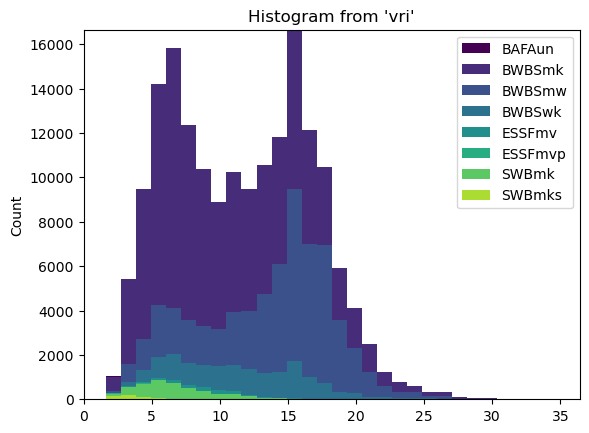

In [35]:
(ggplot("vri", aes(x="SITE_INDEX")) + geom_histogram(bins=30, fill="CONCAT(BEC_ZONE_CODE, BEC_SUBZONE)", cmap='viridis_r'))
# same disclaimer as above - this shows polygon count not area.

In [4]:
import geopandas as gpd

In [ ]:
gdf = conn.sql("select ST_AsText(geom) as geometry, STAND_TYPE_25, prod_bin, POLYGON_AREA from vri where ST_IsValid(geom) == TRUE").to_df()
gdf['geometry'] = gpd.GeoSeries.from_wkt(gdf['geometry'])
gdf = gpd.GeoDataFrame(gdf)

gdf = gdf.dissolve(by=['STAND_TYPE_25', 'prod_bin'], aggfunc='sum')

<Axes: >

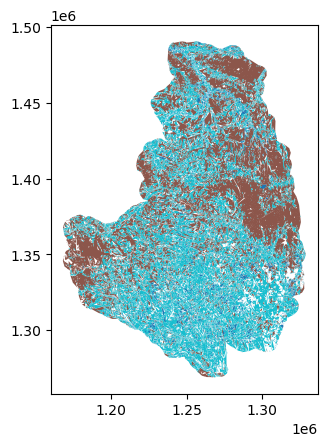

In [15]:
gdf.simplify(1000).reset_index().plot(column='prod_bin')

In [16]:
outfile=r'\\spatialfiles2.bcgov\work\FOR\RNI\DPC\General_User_Data\nross\BRFN_NE_LUPCE_Analysis\VRI_ProdBins_sim100\dissolved100.shp'
gdf.reset_index().simplify(100).to_file(outfile)

In [8]:
conn.close()